# Sequencing using NetworkX
Running sequencing through Pythons `networkx` module.

## Inputs
Using a combination of foundational layers, route through each listing unit (LU) to find the optimal route, by listing block (LB), for field operations to cover every address.

## Outputs
The output of the process is a table (either CSV or database table) in the format defined below. Additionally, start points (geospatial point objects) are produced for collection mapping.

* LU_UID
* LB_UID
* LB_COLCODE
* BF_UID
* BF_COLCODE
* CHAIN_ID
* StartNodeNum - node identifier for BF start vertex
* Start_X_coord
* Start_Y_coord
* EndNodeNum - node identifier for BF end vertex
* End_x_coord
* End_y_coord
* LeftRightFLAG - which side of the road (NGD_AL) this BF represents

Each LU is routed by block, numbering the blocks in order (LB_COLCODE) starting from 1. Further, the block faces (BF_COLCODE) are ordered within each block, starting from 1.

The CHAIN_ID field is always set to 1 for the first block face, otherwise it is set to 0. Unsure what it is actually used for down stream, or why it needs to be maintained.

# Methodology
Before trying to route anything, create a single data set (GeoDataFrame) that contains all the required attributes. This is then loaded into a networkx MultiGraph and run through a eulerian circuit to ensure all edges are covered.

## Process

This process is heavily inspired by the work done solving the Chinese Postman Problem (CPP) at http://brooksandrew.github.io/simpleblog/articles/intro-to-graph-optimization-solving-cpp/. There are however significant deviances from the process presented in the article.

The data set presented here represents the know universe of roads for every LU, and all roads must be traversed at least once in order for the enumeration to be considered successful. Further, every road is considered to have both a left and right side, represented by the `ARC_SIDE` value. Both sides of the road must be enumerated.

### Breakdown of steps
Conceptually, this is a relatively simple problem:

1. Find all road intersections where the number of roads touching that intersection is an odd number. These are considered nodes of odd degree.
2. Add edges to the graph such that all nodes of odd degree are made even. The added edges must be duplicates from the original graph, as people can only navigate on roads. The set of edges should sum to the minimum distance - this is the difficult part to find.
3. Given a starting point (assumed to be the North East corner for this process), find the Eulerian circuit over the augmented data set. Once the roads being doubled back on, calculate the full route from start to end.


## Source Layouts
Below are the fields that are included in each of the input data layers.

### Block Face (BF)
BF_UID
BB_UID
CB_UID
NGD_UID
ARC_SIDE
NGD_STR_UID
CIVIC_LOW
CIVIC_HIGH
CIVIC_LOW_SRC_CDE
CIVIC_HIGH_SRC_CDE
PARITY
ADDR_MDTE
ENTRY_DTE
NTD_MDTE
LB_UID
ALIAS1_STR_UID
ALIAS2_STR_UID
REPPOINT_LATITUDE
REPPOINT_LONGITUDE
REPPOINT_LAMBERT_X
REPPOINT_LAMBERT_Y

### Listing Unit (LU)
LU_UID
POLY_AREA
POINT_X
POINT_Y
LUID
LD_UID
LDID
PRCODE
LUCODE
LDCODE
LU_HID
MULTIPART
I_CSD_ID
I_CSD_OFFNAME
LB_COUNT
SHAPE_Length
SHAPE_Area

### Listing Block (LB)
LB_UID
LU_UID
POLY_AREA
LDID
LFS_UID
PRCODE
CDCODE
CSDCODE
CSD_UID
DACODE
LBCODE
P_CB_UID
LB_COLCODE
LUID
LU_HID
LB_UPDT_DATE
REVIEW_FLAG
S_FLAG
SHAPE_Length
SHAPE_Area

### NGD_AL
NGD_UID
SGMNT_TYP_CDE
SGMNT_SRC
SRC_SGMNT_ID
SGMNT_DTE
ATTRBT_DTE
GEOM_ACC_CDE
STR_CLS_CDE
STR_RNK_CDE
BF_UID_L
BF_UID_R
AFL_VAL
AFL_SFX
AFL_DTE
AFL_SRC
ATL_VAL
ATL_SFX
ATL_DTE
ATL_SRC
AFR_VAL
AFR_SFX
AFR_DTE
AFR_SRC
ATR_VAL
ATR_SFX
ATR_DTE
ATR_SRC
ADDR_TYP_L
ADDR_TYP_R
ADDR_PRTY_L
ADDR_PRTY_R
NGD_STR_UID_L
NGD_STR_UID_R
NGD_STR_UID_DTE_L
NGD_STR_UID_DTE_R
ALIAS1_STR_UID_L
ALIAS1_STR_UID_R
ALIAS2_STR_UID_L
ALIAS2_STR_UID_R
CSD_UID_L
CSD_UID_R
NAME_SRC_L
NAME_SRC_R
STR_NME_PRFX_L
STR_NME_PRFX_R
STR_NME_L
STR_NME_R
STR_TYP_L
STR_TYP_R
STR_DIR_L
STR_DIR_R
STR_MUNI_QUAD_L
STR_MUNI_QUAD_R
STR_PARSD_NME_L
STR_PARSD_NME_R
STR_LABEL_NME_L
STR_LABEL_NME_R
SRCH_NME_L
SRCH_NME_R
SRCH_TYPE_L
SRCH_TYPE_R
SRCH_STR_DIR_L
SRCH_STR_DIR_R
PR_L
PR_R
SRCH_NME_L_ART
SRCH_NME_R_ART
SRCH_STR_DIR_L_ART
SRCH_STR_DIR_R_ART
SRCH_TYPE_L_ART
SRCH_TYPE_R_ART
ARC_LENGTH
SHAPE_Length

In [1]:
import copy
import itertools
from pathlib import Path

import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point

In [2]:
# paths
in_data_path = r'/Users/goatsweater/Projects/stc/sequencing/testdata/Sample_data.gdb'
bf_layer_name = 'BF'
ngdal_layer_name = 'ROADS'
lb_layer_name = 'LB'
lu_layer_name = 'LU'
bf_csv_path = r'/Users/goatsweater/Projects/stc/sequencing/testdata/bf.csv'

# values used throughout
weight_field_name = 'SHAPE_Length'

# DataFrame Creation
Generate a GeoDataFrame from all the input layers to provide all the required information to `networkx`. These are combined to create a single data frame that includes the BF_UID, LB_UID, LU_UID, ARC_SIDE, and node vertex information. Achieving this requires a join of the NGD_AL, LB, LU, and BF layers together.

In [3]:
# define a record reader to avoid loading all of a layers attributes. This is purely to save memory, and won't 
# result in any speedup, but helps manage with large datasets.
# Credit to https://gis.stackexchange.com/questions/129414/only-read-specific-attribute-columns-of-a-shapefile-with-geopandas-fiona
def records(filename, usecols, **kwargs):
    with fiona.open(filename, **kwargs) as source:
        for feature in source:
            f = {k: feature[k] for k in ['id', 'geometry']}
            f['properties'] = {k: feature['properties'][k] for k in usecols}
            yield f

In [4]:
# load the road network
# we don't care about all the columns, so use a feature loader to pull only valuable inputs
lines = gpd.GeoDataFrame.from_features(records(in_data_path, 
                                               ['NGD_UID',weight_field_name], 
                                               layer=ngdal_layer_name))
lines.head()

,NGD_UID,SHAPE_Length,geometry
0,2758288,299.066820,"(LINESTRING (3722405.06 2709708.722857143, 372..."
1,2758636,569.803302,(LINESTRING (3723668.391428571 2710929.4457142...
2,2758874,277.067441,(LINESTRING (3727011.442857143 2714613.6571428...
3,2759085,525.544878,"(LINESTRING (3732677.502857143 2741944.84, 373..."
4,2758996,1033.104971,(LINESTRING (3734456.685714286 2745863.2114285...


In [5]:
# load BF data
#bf = gpd.GeoDataFrame.from_features(records(in_data_path, 
#                                            ['NGD_UID', 'BF_UID', 'BB_UID', 'ARC_SIDE', 'LB_UID'], 
#                                            layer=bf_layer_name))
# This is a table, so make a standard pandas DataFrame, not a GeoDataFrame
bf = pd.read_csv(bf_csv_path, usecols=['NGD_UID', 'BF_UID', 'BB_UID', 'ARC_SIDE', 'LB_UID'])
bf.head()

,BF_UID,BB_UID,NGD_UID,ARC_SIDE,LB_UID
0,18166,36726,1139947,L,36726
1,18168,36705,1139949,L,36705
2,18170,36706,1139951,L,36706
3,18172,36708,1139953,L,36708
4,18175,36709,1139956,L,36709


In [5]:
def table(filename, usecols, **kwargs):
  """Read a table from a data source, gathering only the desired columns.

  Parameters:
    filename: the filename to read data from
    usecols: the columns to pull out of the data source
    kwargs: any additional arguments that should be passed through to fiona
  Returns:
    feature: a geojson feature with the usecols as properties
  """

  with fiona.open(filename, **kwargs) as source:
    for feature in source:
      f = {k: feature['properties'][k] for k in usecols}
      yield f
        
bf_all = pd.DataFrame.from_records(table(in_data_path, 
                                         ['NGD_UID', 'BF_UID', 'BB_UID', 'ARC_SIDE', 'LB_UID'], 
                                         layer=bf_layer_name))
bf_all.head()

,ARC_SIDE,BB_UID,BF_UID,LB_UID,NGD_UID
0,L,36726,18166,36726,1139947
1,L,36705,18168,36705,1139949
2,L,36706,18170,36706,1139951
3,L,36708,18172,36708,1139953
4,L,36709,18175,36709,1139956


In [6]:
# load LB data
lb = gpd.GeoDataFrame.from_features(records(in_data_path, 
                                            ['LB_UID', 'LU_UID','S_FLAG','LFS_UID'], 
                                            layer=lb_layer_name))
# drop the geometry - it won't be used
lb.drop(columns='geometry', inplace=True)

# only keep S_FLAG LBs
#lb = lb.loc[lb['S_FLAG'] == 1]
lb.head()

,LB_UID,LFS_UID,LU_UID,S_FLAG
0,54924,4662011810142,45519,1.0
1,54937,4662011810142,45519,1.0
2,54945,4662011810142,45519,1.0
3,58319,4662842110072,45605,1.0
4,58320,4662842110072,45605,1.0


In [7]:
bf['ARC_SIDE'] = bf['ARC_SIDE'].astype('category')

In [8]:
# merge everything onto the line network
# a left merge is used to ensure no lines are dropped (BOs)
#lines.merge(bf, how='left', on='NGD_UID', sort=False, copy=False)

# trying it without the BOs
lines = lines.merge(bf, on='NGD_UID', sort=False)
lines = lines.merge(lb, on='LB_UID', sort=False, copy=False)
lines.head()

,NGD_UID,SHAPE_Length,geometry,BF_UID,BB_UID,ARC_SIDE,LB_UID,LFS_UID,LU_UID,S_FLAG
0,2758288,299.066820,"(LINESTRING (3722405.06 2709708.722857143, 372...",8162444,729363,L,829332,5999994x40830,75481,1.0
1,3226901,354.937777,"(LINESTRING (3722405.06 2709708.722857143, 372...",4440203,729363,L,829332,5999994x40830,75481,1.0
2,3226900,493.028036,(LINESTRING (3722414.205714286 2710089.9285714...,8162437,729363,R,829332,5999994x40830,75481,1.0
3,2758636,569.803302,(LINESTRING (3723668.391428571 2710929.4457142...,8162480,729350,L,829334,5999994x40830,75481,1.0
4,3226883,1855.350538,"(LINESTRING (3724191.32 2712264.105714286, 372...",8162485,729350,R,829334,5999994x40830,75481,1.0


NetworkX has no way to convert a geodataframe directly into a Graph based on the geometry column. The start and end point columns thus need to be generated.

Every geometry is actually stored as a MultiLineString, despite there only being one line in them.

In [9]:
# Every geometry is actually stored as a MultiLineString, despite there only being one line in them.
lines['start_node'] = lines.geometry.apply(lambda x: x[0].coords[0])
lines['end_node'] = lines.geometry.apply(lambda x: x[0].coords[-1])
# generate a unique identifier for each node (start and end have unique IDs)
id_scope = len(lines)*2
lines['start_node_id'] = range(1, id_scope, 2)
lines['end_node_id'] = range(2, id_scope+1, 2)
lines.head()

,NGD_UID,SHAPE_Length,geometry,BF_UID,BB_UID,ARC_SIDE,LB_UID,LFS_UID,LU_UID,S_FLAG,start_node,end_node,start_node_id,end_node_id
0,2758288,299.066820,"(LINESTRING (3722405.06 2709708.722857143, 372...",8162444,729363,L,829332,5999994x40830,75481,1.0,"(3722405.06, 2709708.722857143)","(3722691.845714286, 2709793.5457142857)",1,2
1,3226901,354.937777,"(LINESTRING (3722405.06 2709708.722857143, 372...",4440203,729363,L,829332,5999994x40830,75481,1.0,"(3722405.06, 2709708.722857143)","(3722090.5914285714, 2709852.354285714)",3,4
2,3226900,493.028036,(LINESTRING (3722414.205714286 2710089.9285714...,8162437,729363,R,829332,5999994x40830,75481,1.0,"(3722414.205714286, 2710089.9285714286)","(3722691.845714286, 2709793.5457142857)",5,6
3,2758636,569.803302,(LINESTRING (3723668.391428571 2710929.4457142...,8162480,729350,L,829334,5999994x40830,75481,1.0,"(3723668.391428571, 2710929.4457142856)","(3724009.305714286, 2710557.0057142857)",7,8
4,3226883,1855.350538,"(LINESTRING (3724191.32 2712264.105714286, 372...",8162485,729350,R,829334,5999994x40830,75481,1.0,"(3724191.32, 2712264.1057142857)","(3724009.305714286, 2710557.0057142857)",9,10


# Route the roads by LU
Iterate through each LU, routing the network.

This needs to generate a network from the grouped values (a dataframe representing a single LU). 

In [10]:
# group the roads by their parent LU
grouped = lines.groupby('LU_UID')

In [11]:
# normally we want to iterate all of the LUs, but for testing just grab one
# 75481 presents a disconnected network, so a good example to work through difficult areas
# 1672 is a nice easy sample, so we'll work with that
# 54118 is the sample for comparison
group = grouped.get_group(54118)
g = nx.convert_matrix.from_pandas_edgelist(group, 'start_node', 'end_node', True, nx.MultiGraph)

# preview
list(g.edges(data=True))[:3]

[((5194961.445714286, 1898936.5914285714),
  (5196526.962857143, 1898566.4142857143),
  {'NGD_UID': 2077952,
   'SHAPE_Length': 1608.6873660454746,
   'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x113dd94a8>,
   'BF_UID': 11552475,
   'BB_UID': 326737,
   'ARC_SIDE': 'L',
   'LB_UID': 326737,
   'LFS_UID': '4772601010343',
   'LU_UID': 54118,
   'S_FLAG': nan,
   'start_node_id': 27169,
   'end_node_id': 27170}),
 ((5194961.445714286, 1898936.5914285714),
  (5196526.962857143, 1898566.4142857143),
  {'NGD_UID': 2077952,
   'SHAPE_Length': 1608.6873660454746,
   'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x113dd94a8>,
   'BF_UID': 11552476,
   'BB_UID': 1521486,
   'ARC_SIDE': 'R',
   'LB_UID': 791526,
   'LFS_UID': '4772601010343',
   'LU_UID': 54118,
   'S_FLAG': nan,
   'start_node_id': 27177,
   'end_node_id': 27178}),
 ((5194961.445714286, 1898936.5914285714),
  (5195335.594285714, 1900492.12),
  {'NGD_UID': 2077945,
   'SHAPE_Length': 159

In [12]:
# test for connectivity before trying to analyze an unconnected graph, which will throw errors
nx.is_connected(g)

True

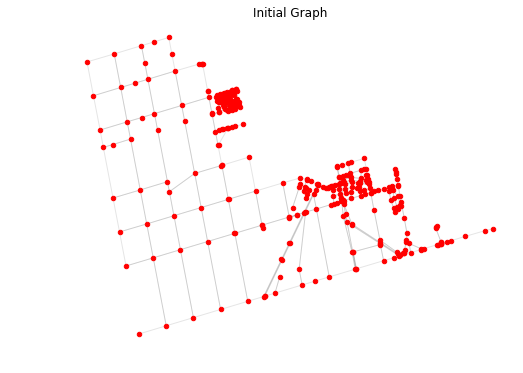

In [13]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[0][0], -node[0][1]) for node in g.nodes(data=True)}

# visualize the fully connected graph
plt.figure(figsize=(8,6))
pos_random = nx.random_layout(g)
nx.draw_networkx_nodes(g, node_positions, node_size=20, node_color="red")
nx.draw_networkx_edges(g, node_positions, alpha=0.1)
plt.axis('off')
plt.title('Initial Graph')
plt.show()

In [20]:
nx.node_boundary(g,g.nodes())


set()

## Step 1: Find nodes of odd degree
This finds nodes that are dead-ends and intersections

In [14]:
nodes_odd_degree = [v for v,d in g.degree() if d % 2 == 1]
# preview
nodes_odd_degree[:3]

[(5200475.762857143, 1894320.582857143),
 (5201460.208571428, 1894117.6285714286),
 (5201533.64, 1894063.8714285714)]

In [15]:
print("Number of nodes of odd degree: {}".format(len(nodes_odd_degree)))
print("Total number of nodes: {}".format(len(g.nodes())))

Number of nodes of odd degree: 16
Total number of nodes: 364


## Step 2: Find mininum distance pairs
The heart of the problem of routing every single edge.

1. Compute all possible pairs of odd degree nodes.
2. Computer the shortest path between each node pair calculated in 1.
3. Create a complete graph connecting every node pair in 1 with shortest path distance attributes calculated in 2.
4. Compute a minimum weight matching of the graph calculated in 3. This means finding the shortest possible distance while doubling back on existing roads.
5. Augment the original graph with the shortest path between the node pairs calculated in 4.

### Step 2.1: Compute the node pairs
Compute all possible pairs of nodes of odd degree. The graph is undirected, so the order doesn't matter (i.e. `(a,b) == (b,a)`).

In [16]:
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))
odd_node_pairs[:3]

[((5200475.762857143, 1894320.582857143),
  (5201460.208571428, 1894117.6285714286)),
 ((5200475.762857143, 1894320.582857143), (5201533.64, 1894063.8714285714)),
 ((5200475.762857143, 1894320.582857143),
  (5201800.202857142, 1895702.8257142857))]

In [17]:
print("Number of odd node pairs: {}".format(len(odd_node_pairs)))

Number of odd node pairs: 120


The time required to solve the CPP grows exponentially with the number of pairs here. For example, 3,600 odd node pairs means trying to optimize ~6.5 million pairs.

This can be validated with the following check:
```
# pairs = n choose r = n! / r!(n - r)!
```

If `nodes_odd_degree` == 36, then you have `36! / 2!(36 - 2)! = 630` pairs, which should be fast.

### Step 2.2: Compute shortest paths between node pairs
`networkx` has an implementation of Dijkstra's algorithm to compute the shortest path between two nodes. This function is applied to every pair in `odd_node_pairs`.

In [18]:
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute the shortest distance between each pair of nodes in a graph.
    
    Returns a dictionary keyed on node pairs (tuples).
    """
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

In [19]:
odd_node_pairs_shortest_paths = get_shortest_paths_distances(g, odd_node_pairs, weight_field_name)
# preview is a little funny because you can't slice a dict
dict(list(odd_node_pairs_shortest_paths.items())[:3])

{((5200475.762857143, 1894320.582857143),
  (5201460.208571428, 1894117.6285714286)): 2436.398496093303,
 ((5200475.762857143, 1894320.582857143),
  (5201533.64, 1894063.8714285714)): 2475.833462514013,
 ((5200475.762857143, 1894320.582857143),
  (5201800.202857142, 1895702.8257142857)): 2586.238245242038}

### Step 2.3: Create the complete graph
A complete graph is a graph where every node is connected to every other node by a unique edge. For an in-depth explanation, see https://en.wikipedia.org/wiki/Graph_theory.

`create_complete_graph` is defined to calculate the complete graph based on distances calculated in 2.2. The `flip_weights` parameter is used to transform the `distance` to the `weight` attribute where smaller numbers reflect large distances and high numbers reflect short distances. This is necessary for step 2.4 where minimum weight matchines is calculated on the complete graph.

`networkx` only implements a `max_weight_matching` function which maximizes, rather than minimizes edge weight. Negating the `distance` attribute gives `weight` then, to ensure order and scale by distance are preserved, but reversed.

In [20]:
def create_complete_graph(pair_weights, flip_weights=True):
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        g.add_edge(k[0], k[1], **{'distance': v, 'weight': wt_i})
    return g

In [21]:
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths)
print("Number of nodes: {}".format(len(g_odd_complete.nodes())))
print("Number of edges: {}".format(len(g_odd_complete.edges())))

Number of nodes: 16
Number of edges: 120


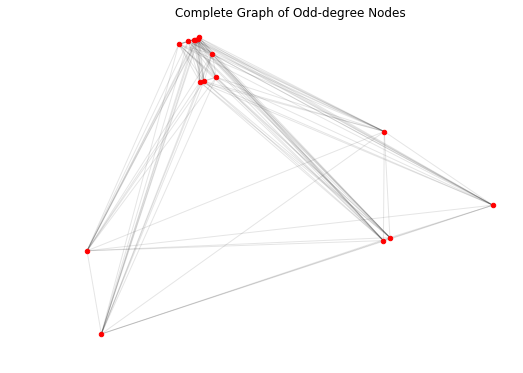

In [22]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[0][0], -node[0][1]) for node in g.nodes(data=True)}

# visualize the fully connected graph
plt.figure(figsize=(8,6))
pos_random = nx.random_layout(g_odd_complete)
nx.draw_networkx_nodes(g_odd_complete, node_positions, node_size=20, node_color="red")
nx.draw_networkx_edges(g_odd_complete, node_positions, alpha=0.1)
#nx.draw(g_odd_complete)
plt.axis('off')
plt.title('Complete Graph of Odd-degree Nodes')
plt.show()

### Step 2.4: Compute minimum weight matching
This is the most complex step in the CPP, and thus requires the most processing time. We need to find the odd degree pairs whose combined sum (weight/distance) is as small as possible. `networkx` has an algorithm for this, appropriately called Max Weight Matching. Thankfully, this can be solved in polynomial time, and the `networkx` implementation will solve this in O(n<sup>3</sup>) time.

In [23]:
# uses the default weight attribute
odd_matching_dupes = nx.algorithms.max_weight_matching(g_odd_complete, True)

In [24]:
# Each edge-pair occurs twice, so this is double the actual edge count we're interested in
print('Number of edges in matching: {}'.format(len(odd_matching_dupes)))

# preview
odd_matching_dupes

Number of edges in matching: 8


{((5196455.668571428, 1905166.8657142858),
  (5195709.571428571, 1902051.657142857)),
 ((5200475.762857143, 1894320.582857143),
  (5201580.937142857, 1895729.0685714285)),
 ((5200968.837142857, 1894203.44), (5201277.908571429, 1894159.5057142857)),
 ((5201460.208571428, 1894117.6285714286), (5201347.774285714, 1894143.7)),
 ((5201533.64, 1894063.8714285714), (5202221.774285714, 1894682.9285714286)),
 ((5201800.202857142, 1895702.8257142857),
  (5202429.2114285715, 1895552.9142857143)),
 ((5211169.282857142, 1897585.6942857143),
  (5216812.348571429, 1900344.1542857143)),
 ((5211463.994285714, 1901558.0), (5211123.494285714, 1901670.4571428571))}

In [25]:
# Convert the dictionary to a list of tuples and dedupe since this is undirected
odd_matching = list(pd.unique([tuple(sorted([k,v])) for k, v in odd_matching_dupes]))
# original throws an error about .items() not existing
#odd_matching = list(pd.unique([tuple(sorted([k,v])) for k, v in odd_matching_dupes.items()]))

In [26]:
# Count
print('Number of edges in matching (deduped): {}'.format(len(odd_matching)))

# preview
odd_matching

Number of edges in matching (deduped): 8


[((5201800.202857142, 1895702.8257142857),
  (5202429.2114285715, 1895552.9142857143)),
 ((5200968.837142857, 1894203.44), (5201277.908571429, 1894159.5057142857)),
 ((5201347.774285714, 1894143.7), (5201460.208571428, 1894117.6285714286)),
 ((5211169.282857142, 1897585.6942857143),
  (5216812.348571429, 1900344.1542857143)),
 ((5201533.64, 1894063.8714285714), (5202221.774285714, 1894682.9285714286)),
 ((5195709.571428571, 1902051.657142857),
  (5196455.668571428, 1905166.8657142858)),
 ((5200475.762857143, 1894320.582857143),
  (5201580.937142857, 1895729.0685714285)),
 ((5211123.494285714, 1901670.4571428571), (5211463.994285714, 1901558.0))]

Visualization of the pairs on the complete graph plotted earlier. Node positions reflect the true graph, but edge distances shows are euclidian. Actual shortest route could be considerably longer.

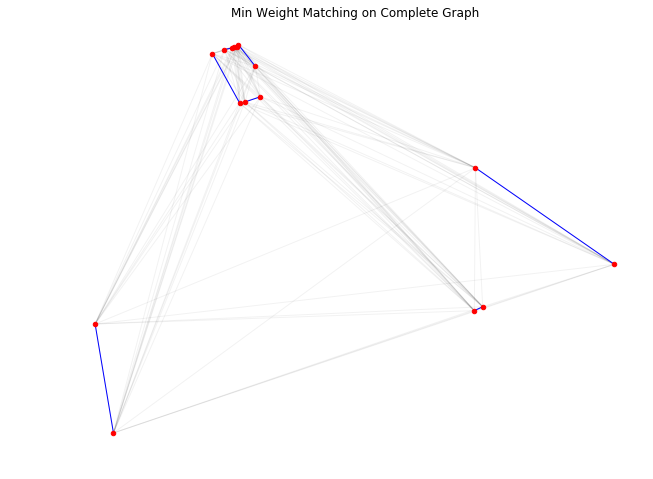

In [27]:
plt.figure(figsize=(8,6))

# Plot the completed graph of odd-degree nodes
nx.draw(g_odd_complete, pos=node_positions, node_size=20, alpha=0.05)

# Create a new graph to overlay on g_odd_complete with just the edges from the min weight matching
g_odd_complete_min_edges = nx.Graph(odd_matching)
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, edge_color='blue', node_color='red')

plt.title('Min Weight Matching on Complete Graph')
plt.show()

Now plot it on the original node map.

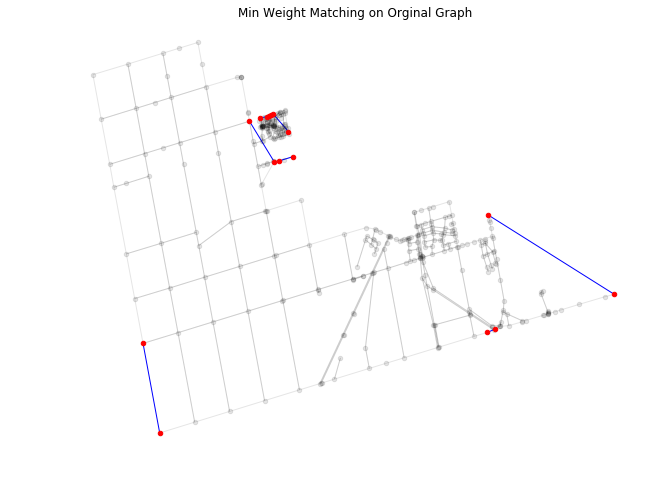

In [28]:
plt.figure(figsize=(8, 6))

# Plot the original trail map graph
nx.draw(g, pos=node_positions, node_size=20, alpha=0.1, node_color='black')

# Plot graph to overlay with just the edges from the min weight matching
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, alpha=1, node_color='red', edge_color='blue')

plt.title('Min Weight Matching on Orginal Graph')
plt.show()

### Step 2.5: Augment the original graph
Augment the original graph with the edges from the matching. The function below augments the graph, and notes the new edges came from the augmented graph. This fact is required when trying to create the Eulerian circuit.

In [29]:
def add_augmenting_path_to_graph(graph, min_weight_pairs):
    """Add the min weight matching edges to the original graph.
    Parameters:
        graph: NetworkX graph
        min_weight_pairs: list[tuples] of node pairs from min weight matching
    Returns:
        augmented NetworkX graph
    """
    
    # use a MultiGraph to allow for parallel edges
    graph_aug = nx.MultiGraph(graph.copy())
    for pair in min_weight_pairs:
        graph_aug.add_edge(pair[0],
                          pair[1],
                          **{'distance': nx.dijkstra_path_length(graph, pair[0], pair[1]),
                             'trail': 'augmented'}
                          )
    return graph_aug

In [30]:
g_aug = add_augmenting_path_to_graph(g, odd_matching)

In [31]:
# Compare edge counts
print('Number of edges in original graph: {}'.format(len(g.edges())))
print('Number of edges in augmented graph: {}'.format(len(g_aug.edges())))

Number of edges in original graph: 862
Number of edges in augmented graph: 870


Every node should now have an even degree

In [32]:
pd.value_counts([e[1] for e in g_aug.degree()])

4     122
6     115
2      76
8      50
10      1
dtype: int64

### Step 3: Compute Eulerian circuit
Given that the graph now has even degree, finding the circuit is relatively easy. There are many circuits that could be constructed, and the NetworkX `eulerian_circuit` function will get us 90% of the way there, with a few limitations.

#### Limitations that are dealt with

1. The augmented graph could (and probably will) contain edges that didn't exist on the original graph. To get the circuit on proper streets, the augmented edges need to be broken down into the shortest path through edges that actually exist.
2. 'eulerian_circuit' only returns the order in which we hit each node. This is resolved because we need to track which edges have been walked already when multiple edges exist between two nodes.

#### Limitations that are *not* dealt with
An assumption is made that the start and end points are the same node. It isn't necessarily the case that we always want this to happen, and in theory a Eulerian path could exist if there are exactly two nodes of odd degree. Knowing when to have a different start and end node could be quite complex, and isn't dealt with.

#### Start Points
The start point for every circuit is always assumed to be the north-east corner. This isn't necessarily always best, and other alternatives should be explored at some point.

In [33]:
# node cordinates are projected, so north-east is always the result of max()
start_point = max(g_aug.nodes())
start_point

(5216812.348571429, 1900344.1542857143)

#### Naive circuit
Calculate a circuit that will almost certainly include augmented edges

In [34]:
naive_euler_circuit = list(nx.eulerian_circuit(g_aug, source=start_point))

In [35]:
# The length of the naive circuit matches the number of edges in the augmented graph
print('Length of naive eulerian circuit: {}'.format(len(naive_euler_circuit)))

# preview
naive_euler_circuit[:3]

Length of naive eulerian circuit: 870


[((5216812.348571429, 1900344.1542857143),
  (5216388.6342857145, 1900427.602857143)),
 ((5216388.6342857145, 1900427.602857143),
  (5215218.874285715, 1900697.8057142857)),
 ((5215218.874285715, 1900697.8057142857), (5214435.457142857, 1900883.8))]

#### Corrected Circuit
Define a function that utilizes the original graph to tell which roads to use to get from node A to node B. This transforms the naive circuit to a Eulerian circuit using only edges that exist in the original graph.

In [36]:
# loop through each edge in the naive circuit, replacing any augmented edge with the shortest path 
# through the original graph
def create_eulerian_circuit(graph_augmented, graph_original, start_node=None):
    """Create the eulerian path using only edges from the original graph."""
    euler_circuit = []
    naive_circuit = list(nx.eulerian_circuit(graph_augmented, source=start_node))
    
    for edge in naive_circuit:
        # get the original edge data
        edge_data = graph_augmented.get_edge_data(edge[0], edge[1])
        
        # this is not an augmented path, just append it to the circuit
        if edge_data[0].get('trail') != 'augmented':
            edge_att = graph_original[edge[0]][edge[1]]
            # appends a tuple to the final circuit
            euler_circuit.append((edge[0], edge[1], edge_att))
            continue
        
#         if edge_data[0]['trail'] != 'augmented':
#             # edge exists in original graph, get the original attributes and add to the final circuit
#             edge_att = graph_original[edge[0]][edge[1]]
#             # appends a tuple to the final circuit
#             euler_circuit.append((edge[0], edge[1], edge_att))
#         else:
        # edge is augmented, find the shortest 'real' route
        aug_path = nx.shortest_path(graph_original, edge[0], edge[1], weight=weight_field_name)
        aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))

        print('Filling in edges for augmented edge: {}'.format(edge))
#         print('Augmenting path: {}'.format(' => '.join(aug_path)))
        print('Augmenting path pairs: {}\n'.format(aug_path_pairs))

        # add the edges from the shortest path
        for edge_aug in aug_path_pairs:
            edge_aug_att = graph_original[edge_aug[0]][edge_aug[1]]
            euler_circuit.append((edge_aug[0], edge_aug[1], edge_aug_att))
        
    return euler_circuit

In [37]:
# prints a lot to note which nonexistent edges are being replaced.
# Unclear how much value this has, and could be silenced.
euler_circuit = create_eulerian_circuit(g_aug, g, start_point)

Filling in edges for augmented edge: ((5211463.994285714, 1901558.0), (5211123.494285714, 1901670.4571428571))
Augmenting path pairs: [((5211463.994285714, 1901558.0), (5211329.488571429, 1901489.36)), ((5211329.488571429, 1901489.36), (5210322.717142858, 1900975.5857142857)), ((5210322.717142858, 1900975.5857142857), (5210331.437142857, 1901024.1057142857)), ((5210331.437142857, 1901024.1057142857), (5210339.697142857, 1901070.0771428572)), ((5210339.697142857, 1901070.0771428572), (5210532.122857143, 1901807.78)), ((5210532.122857143, 1901807.78), (5211123.494285714, 1901670.4571428571))]

Filling in edges for augmented edge: ((5196455.668571428, 1905166.8657142858), (5195709.571428571, 1902051.657142857))
Augmenting path pairs: [((5196455.668571428, 1905166.8657142858), (5198022.78, 1904791.3371428573)), ((5198022.78, 1904791.3371428573), (5197275.308571428, 1901678.4257142858)), ((5197275.308571428, 1901678.4257142858), (5195709.571428571, 1902051.657142857))]

Filling in edges for

In [38]:
# Length of the full circuit is longer than the naive circuit
print('Length of Eulerian circuit: {}'.format(len(euler_circuit)))

# Preview some of the final solution
for i, edge in enumerate(euler_circuit[:3]):
    print(i, edge)

Length of Eulerian circuit: 921
0 ((5216812.348571429, 1900344.1542857143), (5216388.6342857145, 1900427.602857143), AtlasView({0: {'NGD_UID': 4039008, 'SHAPE_Length': 431.8535168226333, 'geometry': <shapely.geometry.multilinestring.MultiLineString object at 0x114842390>, 'BF_UID': 11443748, 'BB_UID': 1529159, 'ARC_SIDE': 'R', 'LB_UID': 1248654, 'LFS_UID': '4772801010222', 'LU_UID': 54118, 'S_FLAG': nan, 'start_node_id': 28379, 'end_node_id': 28380}}))
1 ((5216388.6342857145, 1900427.602857143), (5215218.874285715, 1900697.8057142857), AtlasView({0: {'NGD_UID': 4039007, 'SHAPE_Length': 1200.739279703932, 'geometry': <shapely.geometry.multilinestring.MultiLineString object at 0x113f97f28>, 'BF_UID': 11601974, 'BB_UID': 1529159, 'ARC_SIDE': 'R', 'LB_UID': 1248654, 'LFS_UID': '4772801010222', 'LU_UID': 54118, 'S_FLAG': nan, 'start_node_id': 28349, 'end_node_id': 28350}}))
2 ((5215218.874285715, 1900697.8057142857), (5214435.457142857, 1900883.8), AtlasView({0: {'NGD_UID': 2081383, 'SHAPE_

### Stats
Some statistics on the circuit to assess how reasonable it is.

In [39]:
# Computing some stats
#total_distance_of_circuit = sum([edge[2]['distance'] for edge in euler_circuit])
total_distance_of_circuit = sum([edge[2][0][weight_field_name] for edge in euler_circuit])
#total_distance_on_orig_trail_map = sum(nx.get_edge_attributes(g, 'distance').values())
total_distance_on_orig_trail_map = sum(nx.get_edge_attributes(g, weight_field_name).values())
_vcn = pd.value_counts(pd.value_counts([(e[0]) for e in euler_circuit]), sort=False)
node_visits = pd.DataFrame({'n_visits': _vcn.index, 'n_nodes': _vcn.values})
_vce = pd.value_counts(pd.value_counts([sorted(e)[0] + sorted(e)[1] for e in nx.MultiDiGraph(euler_circuit).edges()]))
edge_visits = pd.DataFrame({'n_visits': _vce.index, 'n_edges': _vce.values})

# Printing stats
print('Distance of circuit: {0:.2f}'.format(total_distance_of_circuit))
print('Distance on original trail map: {0:.2f}'.format(total_distance_on_orig_trail_map))
print('Distance retracing edges: {0:.2f}'.format(total_distance_of_circuit-total_distance_on_orig_trail_map))
print('Percent of mileage retraced: {0:.2f}%\n'.format((1-total_distance_of_circuit/total_distance_on_orig_trail_map)*-100))

print('Number of edges in circuit: {}'.format(len(euler_circuit)))
print('Number of edges in original graph: {}'.format(len(g.edges())))
print('Number of nodes in original graph: {}\n'.format(len(g.nodes())))

print('Number of edges traversed more than once: {}\n'.format(len(euler_circuit)-len(g.edges())))  

print('Number of times visiting each node:')
print(node_visits.to_string(index=False))

print('\nNumber of times visiting each edge:')
print(edge_visits.to_string(index=False))

Distance of circuit: 439661.55
Distance on original trail map: 417035.87
Distance retracing edges: 22625.69
Percent of mileage retraced: 5.43%

Number of edges in circuit: 921
Number of edges in original graph: 862
Number of nodes in original graph: 364

Number of edges traversed more than once: 59

Number of times visiting each node:
n_visits  n_nodes
       1       63
       2      116
       3      122
       4       56
       5        6
       6        1

Number of times visiting each edge:
n_visits  n_edges
       2      362
       1       88
       3       35
       4        1


# Visualize the solution
The first step is to convert the list of edges into an edge list with plot friendly attributes.

In [40]:
def create_cpp_edgelist(euler_circuit):
    """
    Create the edgelist without parallel edge for the visualization
    Combine duplicate edges and keep track of their sequence and # of walks
    Parameters:
        euler_circuit: list[tuple] from create_eulerian_circuit
    """
    cpp_edgelist = {}

    for i, e in enumerate(euler_circuit):
        edge = frozenset([e[0], e[1]])
        
        # each edge can have multiple paths (L/R), so number accordingly
        if edge not in cpp_edgelist:
            cpp_edgelist[edge] = e
            # label the right edge with the sequence number
            for j, bf in enumerate(cpp_edgelist[edge][2]):
                if cpp_edgelist[edge][2][j]['ARC_SIDE'] == 'R':
                    cpp_edgelist[edge][2][j]['sequence'] = i
                    cpp_edgelist[edge][2][j]['visits'] = 1
        else:
            # label the other edge with a sequence number
            for j, bf in enumerate(cpp_edgelist[edge][2]):
                if not cpp_edgelist[edge][2][j].get('sequence'):
                    cpp_edgelist[edge][2][j]['sequence'] = i
                    cpp_edgelist[edge][2][j]['visits'] = 1
                    continue

#         if edge in cpp_edgelist:
#             cpp_edgelist[edge][2][0]['sequence'] += ', ' + str(i)
#             cpp_edgelist[edge][2][0]['visits'] += 1

#         else:
#             cpp_edgelist[edge] = e
#             cpp_edgelist[edge][2][0]['sequence'] = str(i)
#             cpp_edgelist[edge][2][0]['visits'] = 1
        
    return list(cpp_edgelist.values())

In [41]:
# create the edge list
cpp_edgelist = create_cpp_edgelist(euler_circuit)

# this has the same number of edges as the original graph
print('Number of edges in CPP edge list: {}'.format(len(cpp_edgelist)))

# basically the same thing as the original, just with a few extra attributes
cpp_edgelist[:3]


Number of edges in CPP edge list: 486


[((5216812.348571429, 1900344.1542857143),
  (5216388.6342857145, 1900427.602857143),
  AtlasView({0: {'NGD_UID': 4039008, 'SHAPE_Length': 431.8535168226333, 'geometry': <shapely.geometry.multilinestring.MultiLineString object at 0x114842390>, 'BF_UID': 11443748, 'BB_UID': 1529159, 'ARC_SIDE': 'R', 'LB_UID': 1248654, 'LFS_UID': '4772801010222', 'LU_UID': 54118, 'S_FLAG': nan, 'start_node_id': 28379, 'end_node_id': 28380, 'sequence': 920, 'visits': 1}})),
 ((5216388.6342857145, 1900427.602857143),
  (5215218.874285715, 1900697.8057142857),
  AtlasView({0: {'NGD_UID': 4039007, 'SHAPE_Length': 1200.739279703932, 'geometry': <shapely.geometry.multilinestring.MultiLineString object at 0x113f97f28>, 'BF_UID': 11601974, 'BB_UID': 1529159, 'ARC_SIDE': 'R', 'LB_UID': 1248654, 'LFS_UID': '4772801010222', 'LU_UID': 54118, 'S_FLAG': nan, 'start_node_id': 28349, 'end_node_id': 28350, 'sequence': 1, 'visits': 1}})),
 ((5215218.874285715, 1900697.8057142857),
  (5214435.457142857, 1900883.8),
  Atlas

In [42]:

# convert it to a graph
g_cpp = nx.MultiGraph(cpp_edgelist)

## Retracing steps
Visualization of which edges are walked once (grey), and more than once (blue). This is effectively the corrected version of the naive circuit.

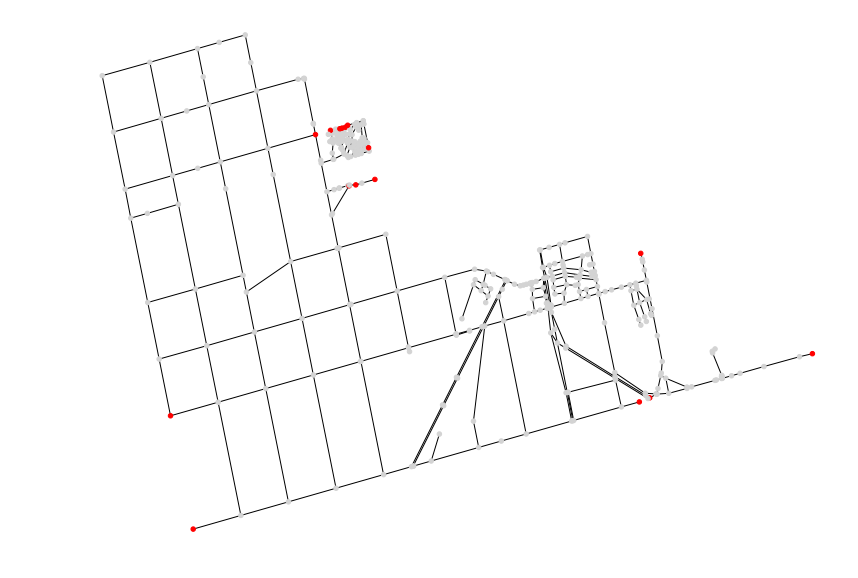

In [43]:
plt.figure(figsize=(14, 10))

visit_colors = {1:'lightgray', 2:'blue', 3:'red', 4:'green'}
#edge_colors = [visit_colors[e[2][0]['visits']] for e in g_cpp.edges(data=True)]
node_colors = ['red'  if node in nodes_odd_degree else 'lightgray' for node in g_cpp.nodes()]

nx.draw_networkx(g_cpp, 
                 pos=node_positions, 
                 node_size=20, 
                 node_color=node_colors, 
#                 edge_color=edge_colors, 
                 with_labels=False)
plt.axis('off')
plt.show()

## Solution sequence
Plot of the original graph annotated with the sequence numbers in which the routes are traversed. Multiple numbers indicate a road that is doubled back on.

In [44]:
# preview the graph
list(g_cpp.edges(data=True))[:3]

[((5216812.348571429, 1900344.1542857143),
  (5216388.6342857145, 1900427.602857143),
  {0: {'NGD_UID': 4039008,
    'SHAPE_Length': 431.8535168226333,
    'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x114842390>,
    'BF_UID': 11443748,
    'BB_UID': 1529159,
    'ARC_SIDE': 'R',
    'LB_UID': 1248654,
    'LFS_UID': '4772801010222',
    'LU_UID': 54118,
    'S_FLAG': nan,
    'start_node_id': 28379,
    'end_node_id': 28380,
    'sequence': 920,
    'visits': 1}}),
 ((5216388.6342857145, 1900427.602857143),
  (5215218.874285715, 1900697.8057142857),
  {0: {'NGD_UID': 4039007,
    'SHAPE_Length': 1200.739279703932,
    'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x113f97f28>,
    'BF_UID': 11601974,
    'BB_UID': 1529159,
    'ARC_SIDE': 'R',
    'LB_UID': 1248654,
    'LFS_UID': '4772801010222',
    'LU_UID': 54118,
    'S_FLAG': nan,
    'start_node_id': 28349,
    'end_node_id': 28350,
    'sequence': 1,
    'visits': 1}}),
 ((5215218.87428

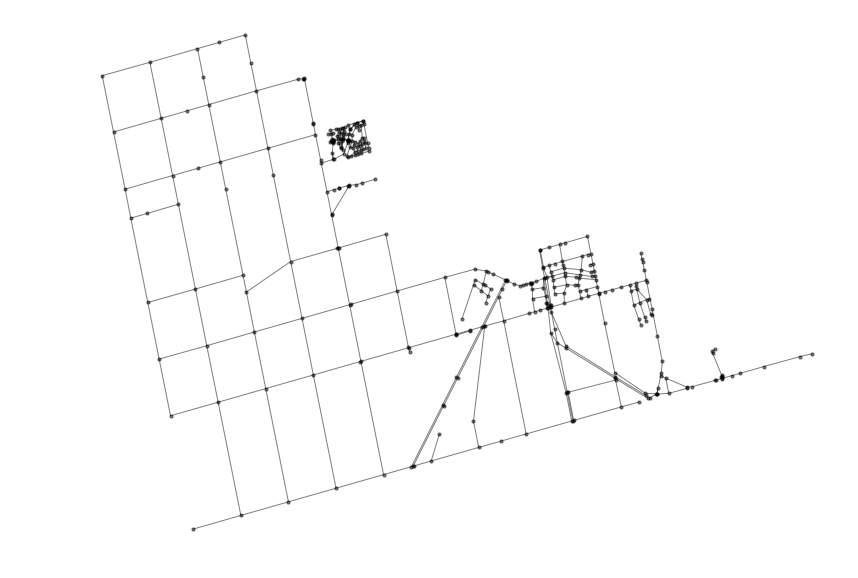

In [45]:
plt.figure(figsize=(14, 10))

#edge_colors = [e[2][0]['color'] for e in g_cpp.edges(data=True)]
visit_colors = {1:'lightgray', 2:'blue', 3:'red', 4:'green'}
#edge_colors = [visit_colors[e[2][0]['visits']] for e in g_cpp.edges(data=True)]
#nx.draw_networkx(g_cpp, pos=node_positions, node_size=10, node_color='black', edge_color=edge_colors, with_labels=False, alpha=0.5)
nx.draw_networkx(g_cpp, pos=node_positions, node_size=10, node_color='black', with_labels=False, alpha=0.5)

bbox = {'ec':[1,1,1,0], 'fc':[1,1,1,0]}  # hack to label edges over line (rather than breaking up line)
edge_labels = nx.get_edge_attributes(g_cpp, 'sequence')
nx.draw_networkx_edge_labels(g_cpp, pos=node_positions, edge_labels=edge_labels, bbox=bbox, font_size=6)

plt.axis('off')
plt.show()

# Formatting output
From the created edge list, create a table that has the proper columns in order.

The desired output format doesn't match the edge list, which is 3D in shape, so it is first flattened and then ordered based on sequence number.

In [46]:
def flatten_edgelist(edgelist):
    """Turn a MultiGraph edge list into a flattened list."""
    for multiedge in edgelist:
        source = multiedge[0]
        target = multiedge[1]
        for edge in multiedge[2]:
            edge_attribs = multiedge[2][edge]
            edge_attribs['source_x'] = source[0]
            edge_attribs['source_y'] = source[1]
            edge_attribs['target_x'] = target[0]
            edge_attribs['target_y'] = target[1]
            yield edge_attribs

edge_sequence = pd.DataFrame.from_records(flatten_edgelist(cpp_edgelist))
#edge_sequence['sequence'] = edge_sequence['sequence'].astype('int')
edge_sequence.sort_values(by='sequence', inplace=True)
edge_sequence.head()

,ARC_SIDE,BB_UID,BF_UID,LB_UID,LFS_UID,LU_UID,NGD_UID,SHAPE_Length,S_FLAG,end_node_id,geometry,sequence,source_x,source_y,start_node_id,target_x,target_y,visits
1,R,1529159,11601974,1248654,4772801010222,54118,4039007,1200.739280,NaN,28350,(LINESTRING (5215218.874285715 1900697.8057142...,1.0,5.216389e+06,1.900428e+06,28349,5.215219e+06,1.900698e+06,1.0
2,R,1529159,11596276,1248654,4772801010222,54118,2081383,805.193378,NaN,28356,"(LINESTRING (5214435.457142857 1900883.8, 5214...",2.0,5.215219e+06,1.900698e+06,28355,5.214435e+06,1.900884e+06,1.0
3,R,1529159,11596280,1248654,4772801010222,54118,4741637,289.350466,NaN,28360,(LINESTRING (5214154.005714286 1900950.9085714...,3.0,5.214435e+06,1.900884e+06,28359,5.214154e+06,1.900951e+06,1.0
4,R,1529159,11596278,1248654,4772801010222,54118,5609521,309.002568,NaN,28368,(LINESTRING (5213853.171428571 1901021.4428571...,4.0,5.214154e+06,1.900951e+06,28367,5.213853e+06,1.901021e+06,1.0
5,R,1529159,11625200,1248654,4772801010222,54118,6066549,44.601080,NaN,28342,(LINESTRING (5213841.011428571 1900978.5314285...,5.0,5.213853e+06,1.901021e+06,28341,5.213841e+06,1.900979e+06,1.0


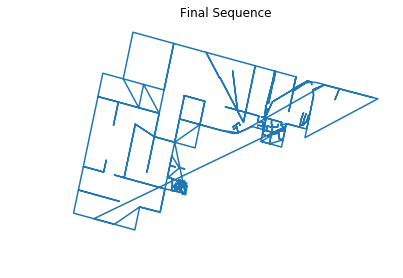

In [47]:
edge_sequence.plot(x='source_x', y='source_y', title='Final Sequence', legend=False)

plt.axis('off')
plt.show()

In [58]:
print("Final edge count: {}".format(len(edge_sequence)))
edge_sequence['LB_UID'].value_counts().head()

Final edge count: 862


1172458    30
1286166    26
1248649    25
1248654    22
1286167    18
Name: LB_UID, dtype: int64

In [49]:
# LU_UID
# LB_UID
# LB_COLCODE
# BF_UID
# BF_COLCODE
# CHAIN_ID
# StartNodeNum - node identifier for BF start vertex
# Start_X_coord
# Start_Y_coord
# EndNodeNum - node identifier for BF end vertex
# End_x_coord
# End_y_coord
# LeftRightFLAG - which side of the road (NGD_AL) this BF represents
lb_grouped = edge_sequence.groupby('LB_UID', sort=False)
lb_colcode = 1
for name, group in lb_grouped:
    edge_sequence.loc[edge_sequence['LB_UID'] == name, 'lb_colcode'] = lb_colcode
    edge_sequence.loc[edge_sequence['LB_UID'] == name, 'bf_colcode'] = range(1, len(group)+1)
    lb_colcode += 1

In [57]:
# check values for lb_colcode
edge_sequence['lb_colcode'].value_counts().head()

33.0     30
102.0    26
31.0     25
1.0      22
77.0     18
Name: lb_colcode, dtype: int64

In [51]:
# check values for bf_colcode
edge_sequence['bf_colcode'].value_counts().head()

1.0    141
2.0    141
3.0    128
4.0    107
5.0     65
Name: bf_colcode, dtype: int64

In [52]:
edge_sequence['chain_id'] = np.where(edge_sequence['bf_colcode'] == 1, 1, 0)
edge_sequence['bf_colcode'] = edge_sequence['bf_colcode'].astype('int')
edge_sequence[['LU_UID','LB_UID','lb_colcode','BF_UID','bf_colcode','chain_id','start_node_id','source_x','source_y','end_node_id', 'target_x', 'target_y', 'ARC_SIDE']].head()

,LU_UID,LB_UID,lb_colcode,BF_UID,bf_colcode,chain_id,start_node_id,source_x,source_y,end_node_id,target_x,target_y,ARC_SIDE
1,54118,1248654,1.0,11601974,1,1,28349,5.216389e+06,1.900428e+06,28350,5.215219e+06,1.900698e+06,R
2,54118,1248654,1.0,11596276,2,0,28355,5.215219e+06,1.900698e+06,28356,5.214435e+06,1.900884e+06,R
3,54118,1248654,1.0,11596280,3,0,28359,5.214435e+06,1.900884e+06,28360,5.214154e+06,1.900951e+06,R
4,54118,1248654,1.0,11596278,4,0,28367,5.214154e+06,1.900951e+06,28368,5.213853e+06,1.901021e+06,R
5,54118,1248654,1.0,11625200,5,0,28341,5.213853e+06,1.901021e+06,28342,5.213841e+06,1.900979e+06,R
